In [1]:
import gym
import torch
import torch.nn as nn
import numpy as np

In [2]:
env = gym.make("HalfCheetah-v4")

/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
print(s_dim)
print(a_dim)

17
6


In [4]:
import torch.distributions as dist

In [5]:
# Policy Network with CNN layers
class PolicyNetCNN(nn.Module):
    def __init__(self, s_dim, a_dim):
        super(PolicyNetCNN, self).__init__()
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),  # Conv layer
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),  # Conv layer
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv layer
            nn.ReLU(),
            nn.Flatten()  # Flatten for fully connected layers
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64 * s_dim, 128),  # 64 channels * input dimension (after convs)
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.fc_mean = nn.Linear(128, a_dim)
        self.logstd = nn.Parameter(torch.zeros(a_dim))  # Make logstd a learnable parameter

    def forward(self, state, deterministic=False):
        # Reshape the state for CNN: [batch_size, channels, input_size]
        state = state.unsqueeze(1)  # Add channel dimension: [batch_size, 1, s_dim]
        feature = self.cnn(state)  # CNN feature extraction
        feature = self.fc(feature)  # Fully connected layers

        # Compute mean and log standard deviation
        mean = self.fc_mean(feature)
        std = self.logstd.exp()  # Standard deviation is exp(logstd)

        # Create a Normal distribution
        distribution = dist.Normal(mean, std)

        if deterministic:
            action = mean  # In a normal distribution, mode = mean
        else:
            action = distribution.sample()  # Sample an action from the distribution

        log_prob = distribution.log_prob(action).sum(-1)  # Sum log probabilities across dimensions
        return action, log_prob

    def choose_action(self, state, deterministic=False):
        feature = self.cnn(state.unsqueeze(1))  # Pass through CNN
        feature = self.fc(feature)  # Pass through fully connected layers
        mean = self.fc_mean(feature)
        std = self.logstd.exp()
        distribution = dist.Normal(mean, std)

        if deterministic:
            return mean
        return distribution.sample()

    # Evaluate a state-action pair (log probability and entropy)
    def evaluate(self, state, action):
        feature = self.cnn(state.unsqueeze(1))  # Pass through CNN
        feature = self.fc(feature)  # Pass through fully connected layers
        mean = self.fc_mean(feature)
        std = self.logstd.exp()
        distribution = dist.Normal(mean, std)

        log_prob = distribution.log_prob(action).sum(-1)  # Sum log probabilities across dimensions
        entropy = distribution.entropy().sum(-1)  # Sum the entropies across dimensions
        return log_prob, entropy


In [6]:

# Value Network with CNN layers
class ValueNetCNN(nn.Module):
    def __init__(self, s_dim):
        super(ValueNetCNN, self).__init__()
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),  # Conv layer
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),  # Conv layer
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv layer
            nn.ReLU(),
            nn.Flatten()  # Flatten for fully connected layers
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64 * s_dim, 128),  # 64 channels * input dimension (after convs)
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        # Reshape the state for CNN: [batch_size, channels, input_size]
        state = state.unsqueeze(1)  # Add channel dimension: [batch_size, 1, s_dim]
        feature = self.cnn(state)  # CNN feature extraction
        return self.fc(feature)[:, 0]  # Output value


In [7]:
policy_net = PolicyNetCNN(s_dim, a_dim)
value_net = ValueNetCNN(s_dim)

In [8]:
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt

class PPO:
    def __init__(self, env, policy_net, value_net, s_dim, a_dim, gamma=0.99, lamb=0.95, max_step=2048, lr=1e-4, max_grad_norm=0.5, ent_weight=0.01, clip_val=0.2, sample_n_epoch=4, sample_mb_size=64, device='cpu'):
        self.env = env
        self.policy_net = policy_net
        self.value_net = value_net
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.gamma = gamma
        self.lamb = lamb
        self.max_step = max_step
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.ent_weight = ent_weight
        self.clip_val = clip_val
        self.sample_n_epoch = sample_n_epoch
        self.sample_mb_size = sample_mb_size
        self.device = device

        # Initialize optimizers for policy and value networks
        self.opt_policy = torch.optim.Adam(self.policy_net.parameters(), lr)
        self.opt_value = torch.optim.Adam(self.value_net.parameters(), lr)

        # Storages for rollout data
        self.mb_states = np.zeros((self.max_step, self.s_dim), dtype=np.float32)
        self.mb_actions = np.zeros((self.max_step, self.a_dim), dtype=np.float32)
        self.mb_values = np.zeros((self.max_step,), dtype=np.float32)
        self.mb_rewards = np.zeros((self.max_step,), dtype=np.float32)
        self.mb_a_logps = np.zeros((self.max_step,), dtype=np.float32)

        # Lists to store metrics for tracking
        self.episode_rewards = []
        self.policy_losses = []
        self.value_losses = []
        self.entropies = []

    # Compute discounted returns and GAE (same as original code)
    def compute_discounted_return(self, rewards, last_value):
        returns = np.zeros_like(rewards)
        n_step = len(rewards)
        for t in reversed(range(n_step)):
            if t == n_step - 1:
                returns[t] = rewards[t] + self.gamma * last_value
            else:
                returns[t] = rewards[t] + self.gamma * returns[t + 1]
        return returns

    def compute_gae(self, rewards, values, last_value):
        advs = np.zeros_like(rewards)
        n_step = len(rewards)
        last_gae_lam = 0.0
        for t in reversed(range(n_step)):
            if t == n_step - 1:
                next_value = last_value
            else:
                next_value = values[t + 1]
            delta = rewards[t] + self.gamma * next_value - values[t]
            advs[t] = last_gae_lam = delta + self.gamma * self.lamb * last_gae_lam
        return advs + values

    def run_episode(self):
        state = self.env.reset()
        episode_len = self.max_step

        for step in range(self.max_step):
            state_tensor = torch.tensor(np.expand_dims(state, axis=0), dtype=torch.float32, device=self.device)
            action, a_logp = self.policy_net(state_tensor)
            value = self.value_net(state_tensor)

            action = action.cpu().numpy()[0]
            a_logp = a_logp.cpu().numpy()
            value = value.cpu().numpy()

            self.mb_states[step] = state
            self.mb_actions[step] = action
            self.mb_a_logps[step] = a_logp
            self.mb_values[step] = value

            state, reward, done, _ = self.env.step(action)
            self.mb_rewards[step] = reward

            if done:
                episode_len = step + 1
                break

        last_value = self.value_net(torch.tensor(np.expand_dims(state, axis=0), dtype=torch.float32, device=self.device)).cpu().numpy()
        # mb_returns = self.compute_discounted_return(self.mb_rewards[:episode_len], last_value)
        # mb_advs = mb_returns - self.mb_values[:episode_len]
        # mb_advs = (mb_advs - mb_advs.mean()) / (mb_advs.std() + 1e-6)

        mb_returns = self.compute_gae(self.mb_rewards[:episode_len], self.mb_values[:episode_len], last_value)
        mb_advs = mb_returns - self.mb_values[:episode_len]
        mb_advs = (mb_advs - mb_advs.mean()) / (mb_advs.std() + 1e-6)


        return self.mb_states[:episode_len], self.mb_actions[:episode_len], self.mb_a_logps[:episode_len], self.mb_values[:episode_len], mb_returns, mb_advs, self.mb_rewards[:episode_len]

    def ppo_update(self, mb_states, mb_actions, mb_values, mb_advs, mb_returns, mb_a_logps):
        # Convert rollout data to tensors
        mb_states = torch.from_numpy(mb_states).to(self.device)
        mb_actions = torch.from_numpy(mb_actions).to(self.device)
        mb_values = torch.from_numpy(mb_values).to(self.device)
        mb_advs = torch.from_numpy(mb_advs).to(self.device)
        mb_returns = torch.from_numpy(mb_returns).to(self.device)
        mb_a_logps = torch.from_numpy(mb_a_logps).to(self.device)

        episode_length = len(mb_states)
        rand_idx = np.arange(episode_length)
        sample_n_mb = episode_length // self.sample_mb_size

        if sample_n_mb <= 0:
            sample_mb_size = episode_length
            sample_n_mb = 1
        else:
            sample_mb_size = self.sample_mb_size

        for i in range(self.sample_n_epoch):
            np.random.shuffle(rand_idx)
            for j in range(sample_n_mb):
                sample_idx = rand_idx[j * sample_mb_size: (j + 1) * sample_mb_size]
                sample_states = mb_states[sample_idx]
                sample_actions = mb_actions[sample_idx]
                sample_old_values = mb_values[sample_idx]
                sample_advs = mb_advs[sample_idx]
                sample_returns = mb_returns[sample_idx]
                sample_old_a_logps = mb_a_logps[sample_idx]

                # Get policy log probabilities and entropy
                sample_a_logps, sample_ents = self.policy_net.evaluate(sample_states, sample_actions)
                sample_values = self.value_net(sample_states)
                ent = sample_ents.mean()

                # Value loss
                v_pred_clip = sample_old_values + torch.clamp(sample_values - sample_old_values, -self.clip_val, self.clip_val)
                v_loss1 = (sample_returns - sample_values).pow(2)
                v_loss2 = (sample_returns - v_pred_clip).pow(2)
                v_loss = torch.max(v_loss1, v_loss2).mean()

                # Policy loss
                ratio = (sample_a_logps - sample_old_a_logps).exp()
                pg_loss1 = -sample_advs * ratio
                pg_loss2 = -sample_advs * torch.clamp(ratio, 1.0 - self.clip_val, 1.0 + self.clip_val)
                pg_loss = torch.max(pg_loss1, pg_loss2).mean() - self.ent_weight * ent

                # Train actor (policy network)
                self.opt_policy.zero_grad()
                pg_loss.backward()
                nn.utils.clip_grad_norm_(self.policy_net.parameters(), self.max_grad_norm)
                self.opt_policy.step()

                # Train critic (value network)
                self.opt_value.zero_grad()
                v_loss.backward()
                nn.utils.clip_grad_norm_(self.value_net.parameters(), self.max_grad_norm)
                self.opt_value.step()

        return pg_loss.item(), v_loss.item(), ent.item()



    def save_metrics(self):


        save_path = 'ppo_cheetha.pt'
        torch.save({

            'policy_net_state_dict': self.policy_net.state_dict(),
            'value_net_state_dict': self.value_net.state_dict(),
            'episode_rewards': self.episode_rewards,
            'policy_losses': self.policy_losses,
            'value_losses': self.value_losses,
            'entropies': self.entropies
        }, save_path)
        print(f"Metrics and model saved at {save_path}")

    def load_model(self, load_dir='ppo_cheetha.pt', device=None):
        if not os.path.exists(load_dir):
            print(f"No model found at {load_dir}")
            return

        # Load checkpoint (device-aware loading)
        checkpoint = torch.load(load_dir, map_location=device or self.device)

        # Load state_dicts for networks
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.value_net.load_state_dict(checkpoint['value_net_state_dict'])

        # Load training metrics
        self.episode_rewards = checkpoint.get('episode_rewards', [])
        self.policy_losses = checkpoint.get('policy_losses', [])
        self.value_losses = checkpoint.get('value_losses', [])
        self.entropies = checkpoint.get('entropies', [])

        print(f"Model and metrics loaded from {load_dir}")

    def moving_average(self, data, window_size=10):
        """Compute moving average for smooth plotting."""
        cumsum = np.cumsum(np.insert(data, 0, 0))
        return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    def plot_metrics(self, window_size=100,save_path=None):
        episodes = range(len(self.episode_rewards))

        # Calculate moving averages
        ma_rewards = self.moving_average(self.episode_rewards, window_size)
        ma_policy_losses = self.moving_average(self.policy_losses, window_size)
        ma_value_losses = self.moving_average(self.value_losses, window_size)
        ma_entropies = self.moving_average(self.entropies, window_size)

        # Plotting
        fig, axs = plt.subplots(4, 1, figsize=(10, 15))

        # Total Rewards per Episode
        axs[0].plot(episodes, self.episode_rewards, label="Total Reward", color='blue', alpha=0.5)
        axs[0].plot(episodes[window_size-1:], ma_rewards, label=f"Moving Avg ({window_size})", color='blue')
        axs[0].set_title("Total Rewards per Episode")
        axs[0].set_xlabel("Episode")
        axs[0].set_ylabel("Reward")
        axs[0].legend()

        # Policy Loss
        axs[1].plot(episodes, self.policy_losses, label="Policy Loss", color='red', alpha=0.5)
        axs[1].plot(episodes[window_size-1:], ma_policy_losses, label=f"Moving Avg ({window_size})", color='red')
        axs[1].set_title("Policy Loss per Episode")
        axs[1].set_xlabel("Episode")
        axs[1].set_ylabel("Policy Loss")
        axs[1].legend()

        # Value Loss
        axs[2].plot(episodes, self.value_losses, label="Value Loss", color='green', alpha=0.5)
        axs[2].plot(episodes[window_size-1:], ma_value_losses, label=f"Moving Avg ({window_size})", color='green')
        axs[2].set_title("Value Loss per Episode")
        axs[2].set_xlabel("Episode")
        axs[2].set_ylabel("Value Loss")
        axs[2].legend()

        # Entropy
        axs[3].plot(episodes, self.entropies, label="Entropy", color='purple', alpha=0.5)
        axs[3].plot(episodes[window_size-1:], ma_entropies, label=f"Moving Avg ({window_size})", color='purple')
        axs[3].set_title("Entropy per Episode")
        axs[3].set_xlabel("Episode")
        axs[3].set_ylabel("Entropy")
        axs[3].legend()

        plt.tight_layout()
        # Save the plot if a save path is provided
        if save_path:
            plt.savefig(save_path, format='png')  # Save as PNG by default, can change to other formats (e.g., 'pdf')
            print(f"Plot saved at: {save_path}")
            plt.show()
        
        plt.show()

    def train(self, max_episode=5000):
        mean_total_reward = 0
        mean_length = 0
        

        

        for i in range(max_episode):
            with torch.no_grad():
                mb_states, mb_actions, mb_old_a_logps, mb_values, mb_returns, mb_advs, mb_rewards = self.run_episode()

            # Train PPO agent
            pg_loss, v_loss, ent = self.ppo_update(mb_states, mb_actions, mb_values, mb_advs, mb_returns, mb_old_a_logps)

            # Track metrics
            self.episode_rewards.append(mb_rewards.sum())
            self.policy_losses.append(pg_loss)
            self.value_losses.append(v_loss)
            self.entropies.append(ent)

            mean_total_reward += mb_rewards.sum()
            mean_length += len(mb_states)

            # Logging
            print("[Episode {:4d}] total reward = {:.6f}, length = {:d}".format(i, mb_rewards.sum(), len(mb_states)))


            # if i > 100 and sum(self.episode_rewards[-5:])>1200:
            #     print("Training done")
            #     self.save_metrics()
            #     break


            if i % 200 == 0:
                print("\n[{:5d} / {:5d}]".format(i, max_episode))
                print("----------------------------------")
                print("actor loss = {:.6f}".format(pg_loss))
                print("critic loss = {:.6f}".format(v_loss))
                print("entropy = {:.6f}".format(ent))
                print("mean return = {:.6f}".format(mean_total_reward / 200))
                print("mean length = {:.2f}".format(mean_length / 200))
                print("\nSaving the model ... ", end="")
                self.save_metrics()
                mean_total_reward = 0
                mean_length = 0

    def test(self, test_episodes=10):
        total_reward = 0

        for episode in range(test_episodes):
            state = self.env.reset()
            episode_reward = 0
            done = False

            while not done:
                state_tensor = torch.tensor(np.expand_dims(state, axis=0), dtype=torch.float32, device=self.device)
                action, _ = self.policy_net(state_tensor)
                action = action.cpu().numpy()[0]
                state, reward, done, _ = self.env.step(action)
                episode_reward += reward

            total_reward += episode_reward
            print(f"Episode {episode + 1} Reward: {episode_reward:.6f}")

        avg_reward = total_reward / test_episodes
        print(f"Average Reward over {test_episodes} episodes: {avg_reward:.6f}")
        return avg_reward


In [9]:
ppo_agent = PPO(env, policy_net, value_net, s_dim=s_dim, a_dim=a_dim)

In [10]:
ppo_agent.load_model()

Model and metrics loaded from ppo_cheetha.pt


In [11]:
ppo_agent.train(max_episode=2001)

/tmp/ipykernel_24968/1962618785.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.mb_a_logps[step] = a_logp
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[Episode    0] total reward = 746.615417, length = 1000

[    0 /  2001]
----------------------------------
actor loss = -0.094295
critic loss = 127.306641
entropy = 6.560678
mean return = 3.733077
mean length = 5.00

Saving the model ... Metrics and model saved at ppo_cheetha.pt
[Episode    1] total reward = 992.797913, length = 1000
[Episode    2] total reward = 920.630920, length = 1000
[Episode    3] total reward = 87.364410, length = 1000
[Episode    4] total reward = 990.824829, length = 1000
[Episode    5] total reward = 991.587524, length = 1000
[Episode    6] total reward = 758.489868, length = 1000
[Episode    7] total reward = 928.997925, length = 1000
[Episode    8] total reward = 941.271973, length = 1000
[Episode    9] total reward = 939.862793, length = 1000
[Episode   10] total reward = 485.387238, length = 1000
[Episode   11] total reward = 980.851196, length = 1000
[Episode   12] total reward = 1123.708252, length = 1000
[Episode   13] total reward = -472.899109, leng

In [12]:
ppo_agent.test()

Episode 1 Reward: 4706.075427
Episode 2 Reward: 4786.697009
Episode 3 Reward: 4670.725080
Episode 4 Reward: 4611.489906
Episode 5 Reward: 4331.231557
Episode 6 Reward: 4678.067650
Episode 7 Reward: 4712.925843
Episode 8 Reward: 4516.510511
Episode 9 Reward: 4770.257521
Episode 10 Reward: 2346.404061
Average Reward over 10 episodes: 4413.038457


4413.038456510991

Plot saved at: ppo_cheetha_metrics


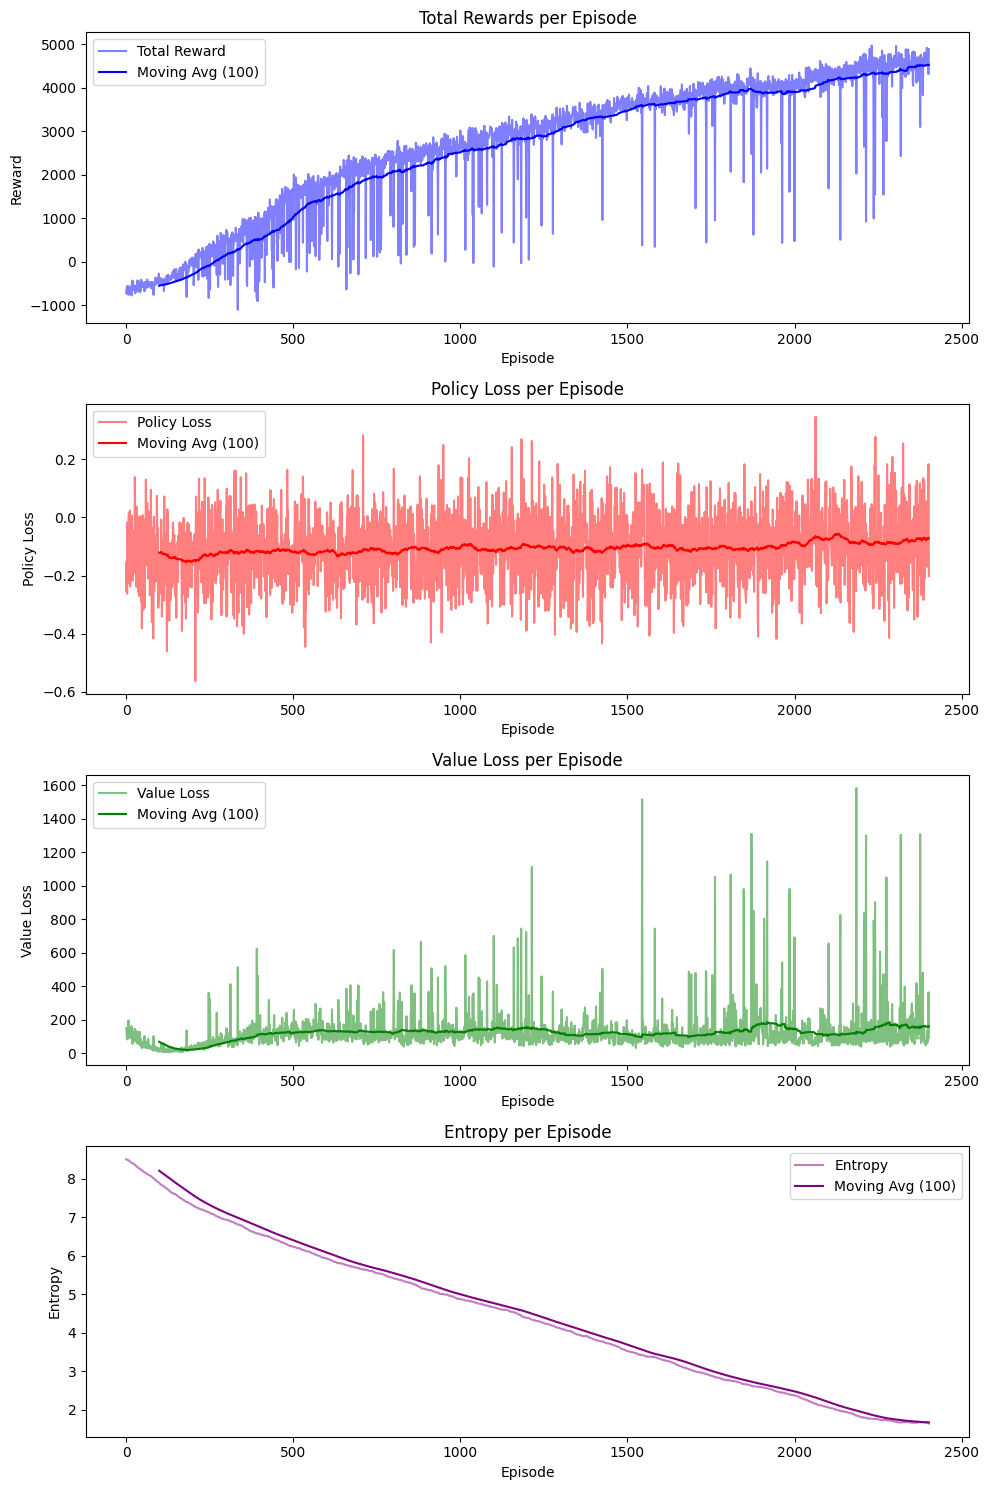

In [13]:
ppo_agent.plot_metrics(save_path='ppo_cheetha_metrics')

In [14]:
import gym
from gym.wrappers import RecordVideo
import torch
import numpy as np

# Assuming policy_net and value_net are defined elsewhere

# Create the HalfCheetah environment
env = gym.make('HalfCheetah-v4', render_mode='rgb_array')  # Use 'rgb_array' for video recording
# env = gym.make('HumanoidStandup-v4')

# Wrap the environment for recording video
# Set a specific directory for video recording, and record every episode
env = RecordVideo(env, './videos', episode_trigger=lambda episode_id: True)

device = 'cpu'  # Assuming you're working on CPU

# Run multiple episodes and save videos
for i in range(5):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        # Convert state to tensor
        state_tensor = torch.tensor(np.expand_dims(state, axis=0), dtype=torch.float32, device=device)
        
        # Get action and value from the networks
        action, a_logp = policy_net(state_tensor)
        value = value_net(state_tensor)
        
        # Convert action back to numpy and step in the environment
        action = action.cpu().numpy()[0]
        state, reward, done, info = env.step(action)
        total_reward += reward
    
    print(f"Episode: {i} Rewards: {total_reward}")
    
    # The video is automatically saved for each episode in the './videos' directory.

env.close()


/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /home/janak/Documents/Pytorch_CPU/Continuous_Actions/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/janak/

Episode: 0 Rewards: 4833.89460511728
Episode: 1 Rewards: 4379.92923408558
Episode: 2 Rewards: 4438.994374137768
Episode: 3 Rewards: 4977.609765050514
Episode: 4 Rewards: 4484.0812013508385
